<a href="https://colab.research.google.com/github/karipuf/crypto/blob/master/crypto_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting stuff up

In [ ]:
#@title Imports


from Historic_Crypto import HistoricalData,Cryptocurrencies,LiveCryptoData
import loguru,pylab as pl,mlflow,pyspark,lightgbm,sklearn,pandas as pd,\
numpy as np,pyspark.sql.functions as F,re
from pyspark.sql.window import Window
from itertools import count
from functools import reduce
from lightgbm import LGBMRegressor,LGBMClassifier
from loguru import logger

spark=pyspark.sql.SparkSession.builder.getOrCreate()
root_path="/content/drive/MyDrive/cryptooo/"

mlflow.set_tracking_uri(f"{root_path}mlflow")
mlflow.set_experiment("cryptooo")
logger.add(open(f"{root_path}logs/log1","w+"))


1

In [ ]:
#@title Local definitions
# Local definitions

rollback=lambda l,n:Window.orderBy("time").rowsBetween(-(l+n),Window.currentRow-n)
def rollingRows(coins=['btc','eth','ltc'],winlens=[3,7],
                avg_kpis=["open","close","volume"],
                min_kpis=['low'],max_kpis=['high'],lag=3):
  
  rows=[]
  for l in winlens:
    rows.append([F.avg(tmp).over(rollback(l,lag)).alias(f"{tmp}_rolling{l}") for tmp in 
    (f"{coin}_{kpi}" for coin in coins for kpi in avg_kpis)])
    rows.append([F.min(tmp).over(rollback(l,lag)).alias(f"{tmp}_rolling{l}") for tmp in 
    (f"{coin}_{kpi}" for coin in coins for kpi in min_kpis)])
    rows.append([F.max(tmp).over(rollback(l,lag)).alias(f"{tmp}_rolling{l}") for tmp in 
    (f"{coin}_{kpi}" for coin in coins for kpi in max_kpis)])

  return reduce(lambda x,y:x+y,rows)

### Get some data to play about with

In [ ]:
#@title Download data
# Generate list of currencies
pf=Cryptocurrencies(coin_search="USD").find_crypto_pairs()

for fname,symb in [("btc.csv","BTC-USD"),
                   ("eth.csv","ETH-USD"),
                   ("ltc.csv","LTC-USD")]:
  try:
    pf_ = pd.read_csv(f"{root_path}/data/{fname}")
  except FileNotFoundError:
    pf_ = HistoricalData(symb,3600,'2020-08-01-00-00').retrieve_data()
    pf_.to_csv(f"{root_path}/data/{fname}")

  # Creating pandas and spark dataframes
  varname=re.compile("(\S+)\.csv").findall(fname)[0]
  exec(f"p{varname}=pf_")
  exec(f"d{varname}=spark.createDataFrame(p{varname}.reset_index())")

  logger.info(f"Created p{varname} and d{varname}")

Connected to the CoinBase Pro API.
Found 133 instances containing the term USD.


2021-09-11 18:03:37.267 | INFO     | __main__:<module>:19 - Created pbtc and dbtc
2021-09-11 18:03:38.207 | INFO     | __main__:<module>:19 - Created peth and deth
2021-09-11 18:03:39.112 | INFO     | __main__:<module>:19 - Created pltc and dltc


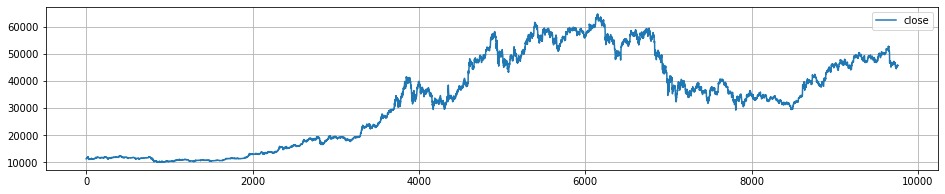

In [ ]:
#@title
pl.figure(figsize=(16,3))
pbtc.plot(y='close',ax=pl.gca())
pl.gca().grid(True)
display(pl.gca())

In [ ]:
#@title Join different sets and simple ETL
# ETL

combined=(reduce(lambda x,y:x.join(y,"time"),
          [dbtc.alias("dbtc"),deth.alias("deth"),dltc.alias("dltc")])
.select("time",*[F.expr(f"d{coin}.{kpi}").alias(f"{coin}_{kpi}")
    for kpi in ('open','close','low','high','volume')
    for coin in ('btc','eth','ltc')]).orderBy("time"))

df=(combined.alias("combined").select("combined.*",*rollingRows())\
.withColumn("row",F.rank().over(Window.orderBy("time"))).where("row>10") # Removing first n rows to allow for rolling windows
.orderBy("time"))

display(df.limit(3).toPandas())

,time,btc_open,eth_open,ltc_open,btc_close,eth_close,ltc_close,btc_low,eth_low,ltc_low,btc_high,eth_high,ltc_high,btc_volume,eth_volume,ltc_volume,btc_open_rolling3,btc_close_rolling3,btc_volume_rolling3,eth_open_rolling3,eth_close_rolling3,eth_volume_rolling3,ltc_open_rolling3,ltc_close_rolling3,ltc_volume_rolling3,btc_low_rolling3,eth_low_rolling3,ltc_low_rolling3,btc_high_rolling3,eth_high_rolling3,ltc_high_rolling3,btc_open_rolling7,btc_close_rolling7,btc_volume_rolling7,eth_open_rolling7,eth_close_rolling7,eth_volume_rolling7,ltc_open_rolling7,ltc_close_rolling7,ltc_volume_rolling7,btc_low_rolling7,eth_low_rolling7,ltc_low_rolling7,btc_high_rolling7,eth_high_rolling7,ltc_high_rolling7,row
0,2020-08-01 11:00:00,11634.38,355.23,59.55,11667.58,356.53,59.92,11561.56,353.35,59.33,11667.58,356.79,59.93,425.599125,4008.054495,5826.619624,11582.455,11654.7600,882.248475,355.5375,356.2675,8957.657220,59.9775,59.8850,16414.317599,11379.70,353.85,58.38,11761.97,358.69,60.72,11448.11000,11500.61125,693.499461,351.51250,353.100,9370.098110,59.2875,59.52625,19287.732063,11245.13,343.75,57.67,11761.97,358.69,60.72,11
1,2020-08-01 12:00:00,11667.58,356.53,59.92,11681.00,357.49,59.88,11645.11,355.89,59.63,11701.00,357.76,59.95,675.329904,6956.531368,7281.749042,11654.755,11678.5075,602.375838,356.2550,357.1375,6839.781067,59.8825,59.8925,13641.727353,11575.61,354.13,58.38,11761.97,360.82,60.44,11500.59375,11554.35500,687.864051,353.09250,354.835,9580.836733,59.5250,59.80500,19635.375762,11278.49,345.44,57.97,11761.97,360.82,60.72,12
2,2020-08-01 13:00:00,11681.00,357.35,59.91,11540.00,353.95,58.99,11490.63,352.95,58.74,11681.00,357.43,59.92,1194.913019,7488.993224,10820.404100,11678.505,11674.1100,400.029166,357.1275,356.8350,6980.833678,59.8825,59.7650,11865.192451,11580.58,351.70,58.38,11738.00,360.82,60.80,11554.33750,11590.87375,660.237394,354.82625,355.865,9893.490802,59.7975,59.86375,17320.020219,11332.66,345.78,58.38,11761.97,360.82,60.80,13


### Quick bit of feature engineering then build simple model

In [ ]:
#@title Feature engineering
# Feature engineering

coins=['btc','eth','ltc']

# Range
featExprs=[f"({coin}_high_rolling{l}-{coin}_low_rolling{l})/{coin}_low_rolling{l} as {coin}_range_rolling{l}" 
           for coin in coins for l in [3,7]]
# Delta close
featExprs+=[f"""({coin}_close_rolling{lpair[1]}-{coin}_close_rolling{lpair[0]})/{coin}_close_rolling{lpair[1]} 
            as {coin}_delta_close_rolling{lpair[0]}_{lpair[1]}""" for coin in coins for lpair in [(7,3)]]
# Volume close
featExprs+=[f"""({coin}_volume_rolling{lpair[1]}-{coin}_volume_rolling{lpair[0]})/{coin}_volume_rolling{lpair[1]} 
            as {coin}_delta_volume_rolling{lpair[0]}_{lpair[1]}""" for coin in coins for lpair in [(7,3)]]

# Day of week
featExprs+=["dayofweek(time) as dow"]

# Label
featExprs+=["(avg(btc_close) over (partition by '1' order by time rows between current row and 2 following)-btc_close_rolling3)/btc_close_rolling3 as label"]


data=df.orderBy("time").selectExpr(featExprs).toPandas()
display(data.iloc[:3,:])

,btc_range_rolling3,btc_range_rolling7,eth_range_rolling3,eth_range_rolling7,ltc_range_rolling3,ltc_range_rolling7,btc_delta_close_rolling7_3,eth_delta_close_rolling7_3,ltc_delta_close_rolling7_3,btc_delta_volume_rolling7_3,eth_delta_volume_rolling7_3,ltc_delta_volume_rolling7_3,dow,label
0,0.033592,0.045961,0.013678,0.043462,0.040082,0.052887,0.013226,0.008891,0.005991,0.213941,-0.046043,-0.175055,7,-0.002165
1,0.016099,0.042867,0.018891,0.044523,0.035286,0.047438,0.010631,0.006447,0.001461,-0.141918,-0.400752,-0.439361,7,-0.005608
2,0.013593,0.037883,0.025931,0.043496,0.041453,0.041453,0.007130,0.002718,-0.001652,-0.650473,-0.417236,-0.459734,7,-0.006014


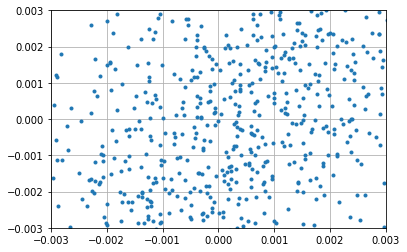

In [ ]:
#@title Train regression model

# Model the bugger!
#####################

numtest=2000
train=data.iloc[:-numtest,:]
test=data.iloc[-numtest:,:]

# Hacked weights - based on ordering and assumes sorted by time - BAD
w_=train.reset_index(drop=True).index
weights=list(w_/np.max(w_))

# Parameters
kwags={'num_leaves':120,'n_estimators':500,'learning_rate':0.05,'boosting_type':'dart'}
mod=LGBMRegressor(**kwags).fit(X=train[[tmp for tmp in train.columns if tmp!="label"]],y=train.label,sample_weight=weights)

# Visualize
#pl.figure(figsize=(16,8))
#pl.plot(mod.predict(test[[tmp for tmp in test.columns if tmp!="label"]]),test.label,'.')
faketest=train.sample(3000)
pl.plot(mod.predict(faketest[[tmp for tmp in faketest.columns if tmp!="label"]]),faketest.label,'.')

axlims=[-.003,.003]
pl.gca().set_xlim(axlims)
pl.gca().set_ylim(axlims)
pl.gca().grid(True)
display(pl.gca())

In [ ]:
#@title Feature importances
# Feature importances

sorted(list(zip([tmp for tmp in train.columns if tmp!="label"],mod.booster_
                .feature_importance(importance_type="gain"))),key=lambda x:-x[1])

[('btc_range_rolling7', 4.2643357321067015),
 ('eth_range_rolling7', 4.1224510847641795),
 ('ltc_range_rolling7', 3.961702994409279),
 ('ltc_range_rolling3', 3.6651834950534976),
 ('btc_range_rolling3', 3.5569493335060542),
 ('ltc_delta_volume_rolling7_3', 3.3604672504116024),
 ('eth_range_rolling3', 3.241905938815762),
 ('eth_delta_close_rolling7_3', 3.0012602200440597),
 ('eth_delta_volume_rolling7_3', 2.891699543186405),
 ('btc_delta_volume_rolling7_3', 2.8301218266933574),
 ('btc_delta_close_rolling7_3', 2.8102712634463387),
 ('ltc_delta_close_rolling7_3', 2.713105438480852),
 ('dow', 2.4144752752690692)]

### Classification model

In [ ]:
#@title Train classification model

numtest=2000
train_bin=data.iloc[:-numtest,:].assign(label=lambda x:x.label.apply(lambda xx:int(xx>0)))
test_bin=data.iloc[-numtest:,:].assign(label=lambda x:x.label.apply(lambda xx:int(xx>0)))

# Hacked weights - based on ordering and assumes sorted by time - BAD
w_=train_bin.reset_index(drop=True).index
weights=list(w_/np.max(w_))

# Parameters
kwags={'num_leaves':120,'n_estimators':500,'learning_rate':0.05,'boosting_type':'dart'}
mod_bin=LGBMClassifier(**kwags).fit(X=train_bin[[tmp for tmp in train_bin.columns if tmp!="label"]],y=train_bin.label,sample_weight=weights)

# Evaluation
pred=mod_bin.predict(test_bin[[tmp for tmp in test_bin.columns if tmp!='label']])
sum(test_bin.label.values==pred)/len(pred)

0.526

### Simple data checks

In [ ]:
# Low and high prices should always bracket all the other prices
df.groupby(*[F.expr(f"{coin}_close between {coin}_low and {coin}_high as {coin}_close_check")
           for coin in ['btc','eth','ltc']],
           *[F.expr(f"{coin}_open between {coin}_low and {coin}_high as {coin}_open_check")
           for coin in ['btc','eth','ltc']]).count().toPandas().T


,0
btc_close_check,True
eth_close_check,True
ltc_close_check,True
btc_open_check,True
eth_open_check,True
ltc_open_check,True
count,131250


In [ ]:
print(f"num_rows: {df.count()}\n\ncolumns:\n-------")
for cols in [df.columns[tmp:tmp+5] for tmp in range(0,len(df.columns),5)]: print(", ".join(cols))


num_rows: 131250

columns:
-------
time, btc_open, eth_open, ltc_open, btc_close
eth_close, ltc_close, btc_low, eth_low, ltc_low
btc_high, eth_high, ltc_high, btc_volume, eth_volume
ltc_volume, btc_open_rolling3, btc_close_rolling3, btc_volume_rolling3, eth_open_rolling3
eth_close_rolling3, eth_volume_rolling3, ltc_open_rolling3, ltc_close_rolling3, ltc_volume_rolling3
btc_low_rolling3, eth_low_rolling3, ltc_low_rolling3, btc_high_rolling3, eth_high_rolling3
ltc_high_rolling3, btc_open_rolling7, btc_close_rolling7, btc_volume_rolling7, eth_open_rolling7
eth_close_rolling7, eth_volume_rolling7, ltc_open_rolling7, ltc_close_rolling7, ltc_volume_rolling7
btc_low_rolling7, eth_low_rolling7, ltc_low_rolling7, btc_high_rolling7, eth_high_rolling7
ltc_high_rolling7, row


### Scratch